In [1]:
%matplotlib inline
import numpy as np
import base64
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [3]:
start = dt.datetime.now()


In [5]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 1987
data_dir = 'dog_data'
#labels = pd.read_csv(join(data_dir, 'labels.csv'))
#sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
#print(len(listdir(join(data_dir, 'train'))), len(labels))
#print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

In [6]:
def read_img(img_id, train_or_test, size):
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

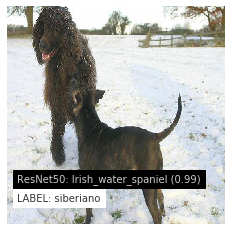

In [7]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(4, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.05)
ax = grid[0]
############################################## BASE 64 ##############################################
imgstring='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICAgLCgoLDhgQDg0NDh0VFhEYIx8lJCIfIiEmKzcvJik0KSEiMEExNDk7Pj4+JS5ESUM8SDc9Pjv/2wBDAQoLCw4NDhwQEBw7KCIoOzs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozv/wAARCAFNAfQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDudOk23iojG5luBubeeFHfFTas32O1fzJBbNjaGCbt2egB/nV6S3sraWWW3hZ53YnEHzPk/oo+tZUvh+61GRZdVZnhVvkgB3P9WYcH6Ck2zNI5i4tBMRcraq9taRs3nFeJmPXBOM4rVttMZ/DtvOkr3EcKBjGq5+YnJwB2FdSdJt5I0SQF4kXCxN91foMVm4u7V305NLkeEPmF4hsRVPUE5zwaSVhtsxtY1gS2gtI41+UqxaA5CKD0II61l+JNfluVktkE0cVwisQ4AyRx0xXbvoun2iyXHlyLNIm1iHxx+PA+tec6vomq2Lm6vYmMMjYWUuG+gP4e1TJySKik3YxwGH0ro/A1naT6xJJd8CCPdEd2MNnr7nFYJARcV2nw2toZJr6V0V2RUVSwzgHOf5VhT1may2Oku7iOYvZz3YU7AUIG1nz/AJ6Vlahq6Wdk6SafHK0fypHOwRHI9yApwOSM9q6W40iwmBZ7ZA2dwdRhgfUHtXlfi3XNVsZJrGDUsQpK0RUyhpDt53EAZA6dT2FdTZgo2Zh6rrqSysbdIBuw2LYAoM84UkAqR3zVOLVfMMjyRNIzx7VZZNqoxYHdtAwRgY2+pzWfLL5jsXbeznL5TPPt79eajD7rYFmxtJyMdfSpsjU1E1BJ5Sk0bFG3BXRyCrdiQc7gDyRxnnBGaLm3M4MtrC6wAKocscyYGN3Pdjk8dM+gqgYpEgSeRMQy7tmOS5XAPTnqelPjMkdsZXeRFY7QoYfexgjHbA749qYizB5CSGXz+EwMyKRuOcYAwc9c84HBrp9O1eWCaFYLq4guiTGroodZATwu3BOfTH4Vx8bzs4Medx64449/XP8AKrNrdRFwNkglDAoyPhSAOMgDPBweop3sCSZ00ut6kbhnu7+6kiL4dJB3HbYxK5B7Y4Ndv4Y1m5u/KRpmnLLvfzdiYJ6hNrfMB6FRgdTnAryfPn3CkSRxq7cuHwFHXHzenPGavWjXmny74Xa2lAyXj46Y53jk5z29RS5hcvY95UkqNwwfQHNOrmvB+sTalpqx3XzTRj/WgjEg9cAYXHHHXv3rpaoAooooAKKKKACiiigAooooAKKKrT3awMQ4wMZyaBN2JyyggEgE9Mmm+fH/AH1644Ncfquuq9u87IGlRmRQpONvrzWFo2p3aMrQyNHbeZuk8x8gUuZE3Z6erq4ypBFOrB0u+hmUXBkWJMkjLYDfhWytxGyb93FMakS0VHFNHMu+Nw69MqcipKCgooooAKKKKACiiigAooooAgutghZ5ApCDI3etUrYQiEpKS5f+HBxz296vzoHiIJAxzkjOKq28CyEMzM6rxhwOT9O1BLQkcUUKgRwiJRnCrjB9zVW7e1W32TsIY2HPyEkn2NaskalPuAlfu5XOKzILS6e5eS5nBj3fKgXOB7+lJhYzlmeWSJrDS5Ht2O0syAA+7Z5xW8lpG9uI3B2g5wDtAPsBUL3yLMY1uImOcBc42/WrEk5+ys9vtZgOGx8uaBoe6RpGS2SAMZJrk9b02S7nZZbspBgsFLEBT7c9anvtQ1l9yQxB9gBLkbUGf1NYd81w9gRJOk0+/Ad0+UfiT0qJNPQpLW5z9/ptqlzIlrcygjGAxB3evIot01mzgWexNzGrttBTa27Hp3rW0zT0nimkn815omyot4t+76noBVptKlS1aeV1stoPlIZSzufZRWKj1Rq5X0Zhx634h0y5+1zrOzAcmdTSR+KtSF21088sUjHKgDKn8K3k0jUdU0dS8ccTd3kDsx/X+lTWPgiG7jkfUZJ7nYNqFHK7D3wO9Fp9GK8OqMzUvF93qtutotu0IdcSuE3uw77Rjis7QprTT9cS2v4s2ErZC3AbCN2yDwa7KLSNS8OMskC/2rZgY8lwFlj/AN3+9WZ4v1XRNV0v/WvBfQEMLadGRz6jBH61fvbt6kPl2SOtaO0htvPsdPV/l3KYUXB+lc3rGt2Zt2F+8JYNlUQkSI386y49Jv1s4ZdMvHs4Z03eQsrHIx29/as+3sI9Lv1urlJJAzbd8qbju78GiUn2KjFPW5QbXtYaRvJvrlkJ+TcxP0rV0jxpeafOY9VV7l2HyGVyuz6CtBLGG4nkubWJoImxsVlGW9Tz0FU/Flhb3OjpcPchriI/IqgHHqPYVK5t7lPkeiRzV1ILu8muSQhlctt9KKgRX2jmisLvuVyxPoBFVFCooUDoAMCnVzz+LYMFEhbzT90E5BpbfxOhs2mnjUMDgKp613cyOc6Cis065aJbiWVwgIBwT601/EGnRpvkmCr2NO6A0njSQYdVYehGax/FVh/aHh+5iBw0a+aPQlecH8KuWes6ffsVtrlHYdVzg1PdFGtJg5G0o2cntihq6Fc8PmyD1rufhkR/xMfX93/7NXCzklsDkV0ngrWYtIh1eaXpFbrKoxnJBxjH1Irkp6SRrLY6bxp4vHh62aGCJpbllBL5wkQbIUtjkklWwB/d5I7+Hz3Ejyu8krOxLMWdskk9SffkmtfxXq6atrNxcRiYbyNhmfc+AMZOOBnk7RwK5+YGNlU9Rg568kfr2rqvcztYsbvMVtuQQPxUf40FWUAt90ngdST6/TrUVkiPJIZWZVxksOop8yCFjtwQRwyE4A7H8aXWxWtrjzJJI8YMjOqIFQE52DOePxyce5qZZClxCyuE2NkMUzz13AY5P4elVUDvExJ2+ZjJH8CjgfhSq4Eig4CKNvzdvUmmBenlVrphJgsoALA/dbGWB46kg8+ppl1GZgJg7ZVBlSxOxegx6D26/hVYS7mDlC6lNoO7k4GAT3FT2sykMroQo+VthAIX8ffvzQGg+wvJIXzgF1fdknaT/sg+/wBK0p9WnuCj3SpIFgESeYifuweu0DjtgHHT3rFDln8xAAc/Mfvfnmr1k/2m4WMPDGsqlm8xjs+UE885PPOKBXOu8CazFZaxHHLqBt4G42s25Wz/AA4xxk459q9djljmTfG6uvqpzXgcETWkjRXkMbAJtDAng568YzXU+DNZuLfWoIfNuJLZgYWXLFBk/KQD0we9CkhWaPV6KarBkDDOCM88U6qAKKKKACiiigAoopryKgy7Ko9zigBScAn0ritQ1q5u9b+xK7QxI3zZIU4781Nr/iW6t7hobdofI6FlO5iO/wBK5x9Vhv3LxwbHQ7S7n5QD6jvWcpdhNXLF/HbNI1tEWVoyWUu2Q2f51n6fHI0clvI6BpJAiIVySe5HoKffX9vp5he2ZJpShVmIyMk8YqTRbZI/EEU1xdplBvdgMjee2ai4WNu00/YkkEnyFMhUVuc9utYeo32raYnkvczBX4AVuo9K0vFWvGK9VY4DtKbVcgqCT3B71ycct1d3IijeWVs5Vc5/WjmCx3Hhe9ezgVJ0W3ik+YZJZmPqR2rsYLqC5UGKRX47GuI0nw9fPcpdatamRlXIO8HPpxXYWNrDbwqyReUTnK+mauMhJNF2is+fUVjdlDIAMDLHFUJNfWKUruV1B+bGcD15q7odzforlh400/7aI5LjZFjO5UyCfrVPVfGEguP9AuYxbBeZAm47vTmi6FzHa0Vxuk6tqFyizXOoorODhMAY9yKvah4jTTLViZFuJcdEGDn/AApXHc6SivPpvGF5cuskCMq4wyN0rsNJvRc2SuxVT3AOcUKQzRpAAOgxQCGGQcj2paoBrruQj1qv9nIZQWYoP4QeBVqkZgoLHoKVgKsWnWkIbbbx5cksxUEnPqasGNfK2KAq4wABVW4vlj4RlLHpUMGoszhHZdx7DpRohXLrQKYSjDcMdehrKGi2gmWW4SOVkJwXQHB7Vp3E6pAW5NYb3hcMR84Q8DHek7DuaD2CeSyxytbhiN3koox7dKltNPt7WLaFBZs4dwC5z6mix2SQjcSfYtV1lViCQCQcjPakkmA2JCibSAMenelZkj5wMnsByafTCFTLHnvk1QEbCViMYUZ9M4rD8X6Ouq6LNwDLApdG2jdkdgfStJ9XgEjphhs/iIxmqeo+IrC3sH+Yu7IQsYGScik7NAnqcFo+s3EekRbriQ/Z2KqmAAo+vWp7rxDa6hZNbzW+1g5bzl5ArkmmYXDoTsBYnaOgo81kbYsilSemcfpXJzNaHQoRtqzYF9dfZwouXNrnG4dU9gDVa+nkNuyC5MkbHHPWmoHDB/MWRkOcAcCrGuzLdR21wiBGI2uox19abu0F0jI2pgct0op4DeoHtRWGocy7Fw3d0gVyWG0YDVYsb+VZR5hdkGeB61CyTEbdhI64NHlXDcgY9hXT7RGfKiaXULmSTBdiAcc1DPNLKeA2PrT1gm9AD60gtZnBHPuaXOCiiCIyq+5HZWHQg4qw+p3yKyPdSkMNpG88ikWxlU/eI+gpz2DOvzFgc8HFDm9g5EZ8kwEbetQzXLW9t5YJzINzkHAwP73qPb6VqNoyuOXc+2OtZes6e8CoiAsvLAHk4GNxx2GCKIpXC5huBK+58kZOCQQcdh+NV3yWV+ASoZQT2/wqxKDCVRW27ckHHTnH58VBMmZce3T9P6V0Ilk2nOYbl2VFZQv8XTrgcd6kmTcS8zZLEHHXNSWNmyIZivLj5AR0FPON2XHA6jFS2NLQpDKJnGec/wCRT1V2RthJBJwpA54waklw2Av3cY/xoRo0Zjk7RwoPGF7CnfQLakbmJyDEjQMUVXDHIY8ZIPp7VGZT5Q2MwJOMA9DUkvzjb0A4LHvUCDDbSSFHpTRL8i3DG85YeZEoClyHcLwBkgerccCpbaYIs6PbLKZYyit/c5BDD6YqJE8llEqFNr7TuBGB0OR1z04pCGV2AdgqAMpxwTj0zRuM3dP1MosYESyGNMOu7ekiDpkeo/kKsWd41hercWp8sE7lVW5UdcVzcbceYQsY7YUjPHQ4q/atnaGEmwDJ79SBnp09qlq2o076HqWn+OJI7ItcxNMwORtGG2+ppf8AhZlszYWwcADqXHWuKjdrMKQP3g++yPvRgeRgHpkYOM+orStrLTtQRVkMkDtnLDAGfoRRzPoJxOl/4WRbc4ti3cYNXbbx5p0+0OjxEg7iw4H0rBt/B1o8rp9vkVlxkNEvQ96sN4EjfIXUmBH/AEzHT86LyFZdy7ceO7Iqdjyox+5tUEVFa/ESFdyXNs74+664GfqKqL4AB5/tLcFPG6H/AOvQ/gAZYpqKru7CPp+tO8hcvmX2+I9moyLOT2G4VyviHxK+tXIZGeOLsmela/8AwryTHyakufUxH/Gm/wDCu5s8ajFkdD5R/wAaHzMLHKpA9wfkkAHXaTzTGL2F1jzCuV+bK9fwrrV+Ht2pyNTi69oyP601vh1dO+W1GFh6FG/xpWYzkLne0gc4G/DfSu78JW1vdaAqLCktw8jb3dN2PemXvgmW5sY7VJbSKSIYEiI2SPerGl+HtY0uFYotRt8qNoIRl4qXFsNmQ+MIlk8OxfZ5POS3fDbRnB6HntWV4JsPtN8rEMgYEM5Utn29BXT6xoVxfactpDJBDgZd3XAJ9sVV0jQNS0y2MEV7bSKSTkhiB9BS5Wh3O1AWKLC8BRxWPq+qpaKsXJd4iy/h3qLTrfVrPTjayT28zYIRzu4B9fWsfVfDer6pdLO95boUTaBhjxWjvbREmY2qtIs0gY7nPDdSDVaDW7iNTDIFLdSrp94e9Tt4G1dZNyXttjOcYb/Cmv4G1hnLteWuTxklv8KnlYFTVZLZ3DTqgmOGAiX5AD2rElKJ8gk3L1xXRN4E1pwf9NtT77m/wqN/AOqRrue4tiB6M2f5UWaDcwrYTXNyoDNsTkseuKsC6uSskSt+5ZvmUt1x0q8bdLBfKOCwGCR0p9p4dnv1JWLbvOQSDg1mpNuxXKkUHuZH27iwH+8OK0NN1OS1Eg+1+Wp4G7mraeB7uRQkipGq9CXzmmt4GnXAe4gEa9CWI5rRRk+hLsdJo3iWxW38uS/Cqv3QwBarr+JNN+3wINTBR0bcQBtB4xk44rjk8EajC7MkkBXHyneeaE8IakGJQwL7MzcGrtJdBHZaj4o06xRW+2iQscbUAP41zup+NpBdqIXDwgcgJ97P41Sl8GapcJmSe3Le7NVAeGNRubx7QywF4gCcs2KPe7CsOvfFt5JKzxkLnjATHH51XTxNdq6SNlsHJXkZqxJ4E1EfxQfXzSP6VFJ4RvYQRJNaBf8Ar4wf5Ump9gsiV/GF6EKyZdc8DceKjj8Vylw7REp6A4ORVF9JMM22RllVfveXJupw0prjalukoXtgFqhyexSR1mj+OLdI2M1qwOeqsP610Gn+LLO+V28t41U4BYjn9a87j8L3r8KsxI6/JVlNC1BIvLNvcAewpxutkB36+JbQXDxSKy8blOVII/OsK+8cu77ILVlQn72QTXMz6PdRKubO5dgOyE1FDa3JdozbyKw6oeCPwolJrQaRLqmu3s9wpMjxoc4TGKorqcjuqXThokyOOD7VZmtL3cGa0mkHZwhOKrvb3kabvsbEDkko3+FJsF3My8jWU5iUgk8kDrUVnDILhPPQlVbOWHWr7zXe3Kwqp9ChGKSCaaSQLIVRT2UVm9C73LL3MSS7I4t0Z5OOADVWZJrmfJxt6gCkulkRysbMyn3quszoxHmMG9M1N9LDLP2Kb+7RVczNnlzn60VIj006PbPyqKc8Z20n9iWo4Cb27itvbu6rjB6UgjIJIxn8q7eVEXMddGtVGWhGRwR1pTotoykCML3HHWtho1K9B+VG3cuGHT0pcq7CuYr6HaqQwjwQckA4wKQaLbEghGUHsep+lbYhUDPBPvRsIAYgtz1xRyrsO5iHSI16KdpHQCuO8c2Kafb2z/ellZlLAYEaLghR7EnnPJIHYV6YqYUjaa4nxvpd7qNxbxwQPKSzBAAVEY2ZJz0znnPoB6UnFIE2eXSLhTIxyS3A9Bip7C1SUNcSAssRAXI6nAx+QovE2IIUALHg49Mc1Yill/s+2jjQbfm6YHOe/rTVnuP0HPdY42HioZgHG/OAaZcXKlxGYyr5wTnimRv8xBIIxxmpcbaopSvoyFnVXKt0HQ+tRs4yMj5c/Nj0ouM5z1J9Kh55JBwPUVSRDZIr/OMPlcZwadHuaXeg4HH1NQgJvUqD7mrMJEZXa5GAMcZw3FJgibeygv5gLYBO7k555P0FJI21SSh3Hhhnr/kVCjK0igKVTPIDc4HvUrsS0gO75nyPrQkU9ixboj7keTauOQT19MfnUsJ8lwshfrghV3YGehHpzVVM7ZJFY4BBBHIyMcflVl3ZXEgAfIBwD97jnPpSYI1ogyrnYqtkKCODkd2/T/GgXr28wcSkkZ+8S2e3eoLVz5KmRtufvKeMAdMnv3I/GlutlxMDNMqkKoywxxznH41MexUje03xFMJklZlLKu1g7bRtA9a9D0SSa505bufgzncFAxhe36V47bIIrhI3DhgcurjGV7Y71614euo5tOjCkqASFR3+bHYe9XHchmswJ6dD3pBGQ24AZx1p4YscZX3ApMOWO4BR0GDVkisSqk/ePoBRsLAMwx7UqoAMEdO5NKztyqqenXNABhV9M0zeDnjPbIozlCGzSgoM7Rk/SjUBpZFwD1xnAprorjLR5z61J8hGDyfpQVU44+maQERtYpFAkjyvZTkipo7aGNdqRqB6AUoUc55p2cD0FNIAwAvCgegpBjGcUpYY5NMLDfjr9BTAcQD0A/Gqmo3EttZvJFbtKyjOFIGPfmrZbacbSD9KqajceXp8xSNpGCH5RSewGG/iuaJgj6bMCVX5WXB+tUrnxPcXEbqsZjzxk/w1NdarJlg9nLGWRB8x9KwZnecsWLbSeoU8fpWMpNbMaQxld3WNQWaQ4ye5NdRpC6tYWywm0WUDoWmAxXOWscr3EZhilnYHOxUOTiultdUuydg01tw45cKamGmrKl5Gg1zrGONOgGe5n/8ArVm62+qf2awltoEUsvKSFj1+lXH1TUAwQaS4PY+apFZ2s3epT2yxtpzLlgcq+/8AQVrKWm5FjRRdZa3UH7Eg2jpuJoKawF5vLZB/swk/zNV/O10xqP7PQrtH3phUf2nW9rL9jgXB6u5p8wrE/k6k6kPqrD/chVaw4bWVtWuPMu5mbH3g21m+taIm1iTcqvaIw6gKzGsq3h1A307SMysTy4T5T9OKUpbAkaYt4CpEjyMQP4nqm9pZuzEKQQevWobuO+jTcHmkY9lUisqVNQeUAwT+4YNSchpGtdH7NAVSRWUjldq80zT9Xeyg8uMDA6KAOKzY4dSDr5lnMiE8t5Tf4VM1hdMo2Qztk9kbP8qh1GndD5bovSeJtQZv3aRhfRjyadb+Jr1mYSRxn0KsRWY+jakiFmtJyreqGmT6HesVKWk7nb12kUKvO4/Zpmw3ie63jaI1XvuOapwa3cpqb3YjSRmH3c9qz00bVlIC2Uhx6rirL6VqcsGxbWSNhwSUJA/SqdSTsLkSNn/hMZET95aRhv8Afp0nii7SBZvsUIRjgEseaxIvD16wxcLKqjoUjIP8qvw6TLC4ZFumwOQYiVNVzy7k8qLEuv6gVDLawDI3YCFj+VYd9eTXzKJrYoxORiMKa2Ht5zky21yR6iFgRUbxzNb+Ulncvzw7xkVEpNrcqMdTDLpCgSQbV6glQxP41FsCgSCJX3DOBitN9FuZ1bfaXO0+kfT8aQaTeQoqrZXBUDGWWufmlbY0SVzMxMeRGij0oq+bO/Q7U0y4ZR0O2ij3he6ej/aU6cnBwcVIsyEA4PNO8sYHQ4pGQbTwM44yM16WpiO3KRxRgc8cfWo0Qg54zjnC1Jsbr1NIA2DqT+tATHc/TNKAR1oPI4U0AG1R36+9Vr+286yuUQqsjwOise2QanOd3KMfQ5p4RTztIPvRe4Hh2vaT9gnZJmxOGKvGBu2gncGDDjnIGBz8pz6Vm2c0aIYZ2KL95GPIU967fxvp9zJdaldRxN9jikiZ2bjazAKdoz0yoz3y3pXASqGkZfmwAQTnoaxa6GiZeNvlt8Mi78lQCNrcdRhqoTo6NtUEn0xXb3Nk2q28Gp3FvGz3cSMzAZBbbzz68Zx1FQxaBp8Cyz3ZaNIomcID80jDoBn3xWfOk9TodH3bp6HEpYy3DOHdYlRdzM5wPoKHRDjanlxBAMFvvn+9V++kTcrzOcAZRQOFz2ArLubszkADCgYwO9Wm5GcoxhvuNuHV3CRH5cAfU9zSo3BDYzuz6c1Gp2KAArM2Sc9qeoOWLY3E4PvVeRlfqWER3QISQ4TJB4wD6fhSLHnBVCe59AasIEfDKcliSc8kBTjn+dQohRztG5iwztPJ79e3apuVYdE8alww2sMEjP5/zqYOoAR8AAcYPJI6En0wKpFdrll/ungdTnr/ACNP3u4AQ9M/Ljt1wKGgTNZWie2g8st5rqyujIPlx90hvQjP0/GrNw7Om8MqMiLKhbJLKeOB+VVLZdkqo0sRiTA3vwpABweeg71He3YdYpFyGVAGwSRg5OGyM9KUVqVJ6FzTy90ywnzJAynaB821vYiug0HWX028AliMq/deF++PT3+tcqrT2F2pltyo+WYRScoyHpgg/MpHf+Vbtglrfu0i/wCiorfL1fr0BPX8RTb1JWx69aXCT2ySJEUVlDBGXaRmpy6gDAz9K5Twrre9v7LuizTAZjd2yWX+6fUiurAXsK1Wpm9BN4yf3YxSF/8AYIpcKBmmgM5BVl2+vegQolQfeBBHbFO8xMZzRs60bFAwQDQMN8Z/iHrzQGQkHzBn6U3y1LZIOfQ07yUbJIH4cUAJtHLeZ/KlUMBy4P8AwHFNMUYUZjLY7U5VC52x4/GgA3HOPlP1U0NuP8K/rQS5Bwv60194AwW/A0AODOTgqu360MMjlM+2aYDJ6fmadvYHBOfoKAF2gg4jNIPLHUYNKGPejeCM8fnQAB0HIo+VuhAPfGDRuA6gfgaN6ZwcUAAGASWH5UAsRlWA+q0MM8BcikC4XkfhjFAC4bpuX8BSFW/2TQCCSNuMUMgOOPpzQAYx0VaUD2pAgx9KChDZB+vNACsABnaSfagovXZSbX/v/pS4PQsaAAgDs1M285w/50/LZ6DHrmgluKAGDKjCgin9+vWmlpFOSARjrmgyYXJQke1Ahfl9VpAoHQKKaHXP+rPP+zRvHXyyaYDuOnH50c5ztH50KwPVCKXevdSKAGksf4T+dJghsbT+dO3L2pDgfMMZoAMqByKYXXP3fl9aUkmlAycZoAj3DsvH0oqfYBxkUUgDikIBpOT2x70FeME5/CqAMKDxx+NKVGM5/KmBMZ+Y80uecFj+VAAWK9FZqGkVFBkIH1NOBJ6GkZAeWQH3IoAFfJ4U4xnrTv0/GmjJ5AOKRg5A4oAyvEWkyanolzaQLGHk3OrOcANycYx3zjNeK3NjNFNIrI+5SHZQMmPOOvoRkD8a9/JbbjNY1z4Y026adprdS1wwZtjlSX5+bI781MlcpOx5hpepXaKttauySBQpVDgOB05xjPb1o1S9umj/ANKuGbaSVDyFyCevFelNpFnpOlhVjRpVXGcAGQ9Mt+HX3z3ry3Xp99w4TBG48gYGfQVjKNmaxm7aHP3kzzEJ820dBjFVtgCjI78mrLDLDJ6nOSOlQELtz1IJ4x1FaGb1d2IgXk4yFBGemc9qlWFpmKxqGKru2/xMB12+vHb2NNcRrHEsUjuzoDKpXaFbceFOeRjHPFWUhMbIwZgc4Zgeme9ICWLYFkCEgEbcd2z2x9Sf1qJUUQtHsB3EAsAdwPfGPXHvSyDy3YZ2Zcc4x35+lIj7FClwFDYyTx+lQWMjQBScKSSOQcbaV42Qgoq5HdT19KlZwhZiF2L0DdSOnH6U513qUP7vI25z044/mKd9QtoJLc/Z4uWVm243jrnp19hVeOYzMwZgSejOvTjuf/rVBhy7CTrnHIqVUBVQMAdSemKpJJENtsuiKGSz+0xyKksb/PC55ZeBuUj6+v8AKtLQ7tYp1iee5C4Ploihw7ngBlJxg9Cc9KxY3EahR0+67A8E9j9OhrQsmg87F6k22Jd0TwKN6k9M5GCueufwpMaOpgdreVZUDLIH3bN/yM2c/LjkHj8fWvT9PukvrSObZs3KDjfmvHNLldnUyuCQ+ZM8dTzx3GecV6p4bkEuneWQisjlXCEkE9iM0RYSRsBYxnH40YQHHGewFCoFzgc+tNeJ2lV1k2qAcqF6ntzWhA4A7/u4HrmnEH1/SgAjqc0ZOAeKAGh1VgpPzHoOak/EgUzf2H40m5SeWJ4zQFx+5M4ByajeUoMlC3+6pNNLoM7cnH4U8FcZoC48MvU0jEHgHn86j+UZJJOenPSm7gTn5qaQrkvGcDilxxgcfjUJLHo2PbHWnbmx2zT5WFyQqSuCcfQ0bQeuDUe9v7v40nmHBPP5UcrC4/yVyTgUnkJg+/ekE44yG59qd5if3gPrxSsF0Bj6YYgD0NNVXZTuG056E5p4IPelBzSGReWynhmPrilVZBzuPPY1L+VJ1/8A10AM+YHJ6H2pN7dx9Md6eSQPx9aDnnAyfpQA0vzhqUOCT7e9Azj5yM+wxRwR60AAIIz0H1oZgq5LbR6kdKQovI24BphiQYUAkdx2oABIC6qSrBhxgVINoGAoH0phjUbQAAoHAHFBTBwKBD9w5yMU3zEztyM/Sl2gdc5+tGzJHPB680wA7c5JFHGc8YpskfQo31zSBUAxvyKAJCPlJBwD3puBtwTnHemDYSVweP1pfl28CgBpUdaFx7U8OjLwwxRtRuCFNMA20VIJWUYGMUUg0GUUZ4oqwCjilA96ABnrSuAmPSgk/WloyKQDN5H8J9u9LznJp3FIcUAG0HP+FNKrjPUj2oJOQM/pQ5+U5J/KgDn/ABE7tbTLGShAwz56D0Hp9a8q1WMB2XHHQD1r2DULATo0jltoBYgKDnH1715TryeXeuG5c84Jzt9M1hNO6ZtG1rGAwKsEK5wMEg9KouvduhOAorQfJYoAuQeMe/eq0qsZFH3QnHTk+tCYpIjiDI+Dnp3rQ/gOeue1Zw+XDEEE85Jz+FXIpBIg56dRRII7jpTuX5sAkYJIzzVdARNjj5gB0569KsyOBGQTg+9Zzu3mjy8ccjHrRHUci2DvB6E5J49KVmXy25VsD6n6moITJK4AQjIwpB6/WkliuInWaVN2DtZw27PpmmokuQ99hBfYN2RyDjFJCUfchZiWQhFRQckYwCD2xnpzmmjc0ZXAwTnke3+NKwLqqpwyIeQuMjOefx/lVCGRSKNylsqeT1xge3pVuF5EcSKzBgeD0OB/MYpLe7keA2EoUwPIXZGCg79u0EP1zj1/rU9o8kMJjG14pSGKsvcdCD1H4H68VLHE3dNiDyLKhRsrkhG24JONoBwffjNegeC7p5DNE8ruVOVLsWOBwR9c/wA688h8z90Q4XzHYb9q7FPGSoAwO3GPpXofhRZG1C6kYJtdUOEJ6+o9Oc/ge9EdxyOu6nrn8KWmFyG2krmn9a0MxCTnAxQDn/8AVS8UdaAGsu4g9MelIUO7cDg4xyKfQeR0NADNhI+Y857DFGz0JpSvTDFfpR0HUmmA0q2OuPbFQvuDYyx9gKn5YdADnvTWXg4JFNCIY3dgQwIIPcUKSGO0ADPPvTwuMA80MqE5IHHrViEEgz3pPM79vYUMgJyfpxRtGMDI+lAC7ufX6U7IxyKYq4JPOaaSwLFWGfQg0AS/TNG51HByajV3IzgH8aSVEkQeY7qF+bKOV/PFISJg/wB3I574GaUzEcBCTn6VDHLHMitG29fWpMsDmpsh3ZLuPoR+FG4dd36VAfNDqY9uCfn3k5x7VNtDdev1pNWHcXIIyOlABPUUY3DHpSgDoDn6UhiGgfnTsDGMn8qMfl9KAG9+cD3pqhlzlgST6YpzMFUnOcegpR8wB5zQA0gkdcUY46U/A9aQD3p3CwzjijaCPalkQum1ZGQ+qgZ/Wjy+5OTRcVhuNvTgU0orHOTn1BqQp6mjGD0BoAjEe0YHT0zRyB92pCM9vypCGPQAfWncLEe6ikczhsKI8UUr+QWHDOOPxoBJ5xj60HjpSjJ5qwEUnPIyKeGU9v1pnG7t707AzipADg9FHPWl2qPb3xUZkO7CxsefSpMMeGwPagYpA9abtAGO1KAR1H0oFAhmwbjjJHfJp+AD/Dj3o6jg/rSbUzkgUWAo6tcrBZyFNpfG1EzjLH+gryDVFVrtvnD8nB9T3NeleKJo4rNnkICoCqL0Lk/0ry+9kZ5yzDk8k+npWFR62N4LS5lSIQxf7vZR7VTfajZLgk5AyPXvV2UlQzt82RVNyCF3DOOgoQpCSgqinIBIx9RTUJTGTgZ5yOlSOQZWbaBgYyeKjYIVAUFucliPzoFYncsUAIJxVYhtynKnnHPb6mpk+Z2yeNucCnworyKQDkHqf/10LQb1Jkb7JEIyoDso3ttp0LsXJcBlK/OmM8d6f5O8MXIwpIyx4GOtQkl0xGnXqzkgH8KpPQhojmgRHYI+UKbkA4bPYYP86II422+fIsfl5ZR1DE84POQO1DRPJgMEbuA2VJ+jdKRYFXLna6lSCP4lI6jHqOvoaWgajEhVJRvKiEsDvHzAfl/LFaIdXsUZI1U7iuFyCrAehJyMd+tVGR4mbDqVXaoTja5PNTIr+WGjRVDDO31we3PuaT1GnY2tOVblGQyZD5ZQWzlsdq73wxbTSn+0IZWhVsK0IB2YGARz1559RXmtl5iKNqLuB3AnIII7/Qj616P4IvoY7O6iuLpY0EgkQysqA7gc4yfUUR3HLY7RAQoy2frRu4Iz+dRQzQToRBcRTHtskU/yNP8AKfpuIweflrUzHBjnJ6dqMKxznke9BXDFi5AHG0DpQqKQWyCGHbpQAKcnpin5UDk81XhhtrZWSJViXdkhTxmpRtUH5s+pJpJjH8dv50hUdzSYxzgfnQMdvzFMQu0L0JpjLkdduO+acTyBn8KQIPx9cdaAISpJ++MemKbsGeVB461YfgZAY+wFRkk/wkfWrWpLEB4wFIHvRn1opadgEzzSmm47GmkMDkMAPSmA5t38OPxpMbl5GPrTGlYE4jc47gcGnI+/qCPagBVUKMEKfwxTjx04phL7vu8euaduGcc0JANMiouWkVfcnFPDtjjmkZVZcMAw9CM1GscauSiYJ6nNAE28EYYAj3pUliGcZU5weMU2mkZ6YxScUK483tuJ/JMgDkZCnvUqup6HrVZlyMdc9acMqchjn+VTyj5icMB3FGO+KhR8N8zkntxih7lkjLmNgeynqal6FXJ/oKZIHEbGPaXx8u88Z96it7iWVN0kLxH+65H9CamLfNgtt/DrRcBlsZ/s6/aQglx8+w/L+GakyabvGcdaC6gnJ6UwF3c45/Kj3qE3cIlEX7wsxxkRtt/PGKl6daBC7vfH1oJ46ik2gsGBII6HNOZzj+GgBMfT86KYd2eGGKKNQEG4krkZoKORkMKVjk468UgIUcfp2p6jAIo5LH8DSgKeMjn1NV5ER5FUyuM87VbGfbpUgTac8kAevSgRP0GN35UgOfWmAcdSM9zTW3F+JAAO2KAJCWH8JI9qASeq4+tIjEE/MCPpTiS3WhDDpxkY7Ypr8DAAPt0zSgE4yPrk0fKSeSuO9Fwscj4sRmb52UKFwABlnbqfwrzfUGJnO4/M5z6V6n4tihSxUIv7x3yz9WK45ryy8QtMzoM9wCK5p/Gbw+EzJ8PIcjnoB7d6icAMpTd8i5APr2qYhef72OophYBM7iQDyfWmSyAoyKGc/Ky+meaQFWQLj7vc80+Uh0I2Y28YpsJ5DP06ADigOthEIdmJH3cfhU0aREgfMrAk/eyP5U122lkCgYwRxzTixdcg5U85B6Cmtwexft4jIEjYqE68n7xNab2sNvb+c5VVA6twFrBSd1dWB2jgZJ6CtfW7Ge50VbmJmZbc5ePHY/xD6fyNTJO6Vxx2uZ7ahHNK0ShpIyOSc8HswNVXlMLnKgNgAn0I6NVJJWicEHaRVi7cT26XCnp8rDuKvlsyOa4tzMjorqwBI6DjGP6j+VMt7l1+VmGB0JGRg9aqM4KcDnqR/WiNyXU1VibmxbMp3Fi2AeFycfpQ7o/9049TzRbpugKs2BnINVZFYOwBLgHGalLUpvQsrMIzlFAPqBg1dsJL+9u4rW2klaWVwqKrsMk/j0qLTNG1LVVZrDT7i6WMgM0a5Ck9s9K9K8BeD7nSZX1LVYFinZNkMJIYoD95jjIBPTH1qvQk6PQ9O/s7SodOuLh7p4l+d2LHLHk4J7DoK0Le2tbSHyYEWOMfw7j3+pqUtGjBCyhmztXPX1xTWO5hgLjHJYUALgDAAGOpOKGcqMqhce1QHzWRvLKhfXv70kToHWNX5696d0IsB84ARgfccUrEDg9/SkVfmPzHA7GnbvmIyOOoxQA0L68enFJuJfaFIHclTg04n5s5XpjgUjoHIPzcdCGxTuADIb+E/wBKawwuSAM+9NaRV+TGT3NSlUwc4xRcLEX1x+FBoOwKFUdT69KDFkYOGxzVqSJsJmjFGNvXimkt26U7kin2FIM9+vtRnB6k0Z/CqAGHHTP0pAB1B49KXoSeaDnHGM0AHAHSkLjOMgZ6U1mdc/IW9MHrUbqsgVnt2YjpngipuUTFiFxuBb1qvLfpDqFnZsR5l0JGA74VQT/OpgqMBlSp9CeleW614hnfxr9sjkIWzn8qIE4G1W2t+fP50N2FY9V3YOKQSITgOM+maiaEEnl2GeMmmeTHGwd4yWHRgP8APNPURbBz6UobHHas+bVbO0lWOW4jRm4CO4DfkasvcjaCEYgjjC5qW/IslKuZFcSHA6ptGDT+WYMoUfUVAJ2Kbgjcfw96lV3K5Ee5vQnFToA9kd0IBwccGqttb6gkrm7mhlQ/cCJtK/U5q4rP1xgdsUMu5wSxBHbNS09yvIhVHDtsLHPctnFKXdT8wGPU1KqYOcL+eaVsAZYqBTuKxAJJFYnG5TzmlEzFVJRvmPQc4HrTZZiJo4hbtIsnV1IAQep71OEAHGAKVwsIDkZ+WijGOMn86KoRAg2Hb2x3NSbOAcc07YwGNuPoaXDDIc8EdKLsdhoRu5+nFI8KuwzIy47KcZo4bkPx2o2gOcD5vWh3YCPAAAxZjgY4brVS/wBQWwt1mMbSKzBSAdpFXNoOMgE+ppvlKzhnCsQeMr0pNO2m401fUSGaO4jV0JIZc+1P3Pn7o2+uacpAGAoGOwGKTLhySuQfQ09RCAE555oC4Y4yCep6inhxxx16U7fzjbilcLGF4jheTTmWNFLylYlYnHJNef3+izWyzM6MwUhSythc99o7/XivVG3SXKiWJdqDKuDnBP8A9aqNzZxiaZ2iEjNzu2Z2qOw/LrWckpO5cZOKseKX1tHbXjJE0nlqqnEi4OSOePrVNwgVUySF+Y4rp/FFq8MxuJUKzT5kYlcA84Cr9B/OuZYAOWI+9xxUlX0IZPnYnODjPWmoFCqxYZPYdRj1pZkVWGOvv2pMxlAEwFB5wKfQXUNrORyd3seamWTykyybgSTgjg/5NNCYPzMxZxj6VHuZh5ZyCBuUHt6ihbg9gcluU4bBYDPSt3SdZlsrdmkfaJF53Lkn+n4VggbJFBbcMjgZwFPXgiugbQZCy3U1ysi7MKFXAxRK3UI36GD9l+03biEEQliVOMYFLdokFuyrnDdM1ss0FojBmUD0Heud1G8NzL8q4VaItyfkEkkiq+Bgd6kh6jmodjsm89PelRtpxnn1rUyOgsXDptBAYDoav6Xocuq3CxieO2jLZMrqW/AKOSfyrAtnYHcvDfSvWvD9npt1olrdRvMAFUERHJRx1zxzz7VlJNaovm0NjwnYw+G9JFkbr7U00rSlljKYJwMBck4wK6Tc5TcqrnHAJrP09LVIFaOMLL0JZtz/AImtBUyW3Ofwqo3tqIVArgMyruHUelPwMf8A16jFrCn7xcg45YN1pHcIpbnA6kCncB4ULgnGewHanYzj09arTXHlwNMiNKFGdkYyzfQVWeW8uFR4Wkt1yDtePax+ue1J3Ww0jSYoinJHPc1Ak8TyNGhYlep2nb+B6UqKSAXYsfTsKbLcRwyRxuzKZDhcdKYiTeoAGDz0yacDkEciohKA4QIzH6Zp5mw5XymAAyWI4pKVwsDx7sZGe+aRiwGERiSeppzPuI2qD689KbvdeqE/SqAaqyDkKAx9RSMJNg3YLZ5CtgU8SBmKk7fY8GlOAmS+fcijQRWbIlASORxjls8Ch2dDkxYH1GamVdyn5twPZe1IYyTh1GexXNNMTRGrZ6tz6elNdwrgA4PpjrTjbKsglJYkDA54x9KjkjE0ZAdo+2V4NaJ3JsDShFJ/T1pwcsoKqcHvVCGwitGMjXE7jqUmYNj1Iz0/CpUvbWRmjjk3GM7Wxk4JoUgsWg55O38RUbzJkDcQe22q9zfQ2bIs0jDzWwtWEEcyZRsg9waYxF82SUFLgoARwEDEc14fqrlNavUk6i5lzxjnca9yUyo67nUKOSSOw614Nqlyt1q97cxglZbl3Q+oLEj+dJrQSPZXu4bjR4J31Ka3VIwzvEB85Awwzj1Bq5ZJbrBHNBJJOrLuVi5bdnvjNU9BttvhnT4Nyuv2ZAcjh88k/Qkn61dtrYWyeVFG4Qfd3N8q/TvQlcL6WJ8LK+XtxkdC6jNPIyMgDI6U0M3ABGe+TTGR3YMWUL3FUIl3Z9Rg8inrJH3BAFRKipwMnPc807Bxw3ep5bjvYmWWMjhT7A0LMrn/AFbZB54qJSByMA04MexAPak42GmPZ9h5BH/AaEZixKuxU/wlOB9DTA2Sfm57nOamEgdflf8AIVDRVxpZckqDn1xSBCVPmNtPXGaFQ5JDN9TxQUUOGZyPcN1/CnsIa0GWJ8xqKfgDj5/++qKAsL5j8nbx2qpcwT3TFGnMUZHOwcn8e1XRtYUBUHOPxNJpDI1SNQAoxjjPtTg6Ec4z29afsQ4OBmoJIggZ03sf7oIFHoA8qAM4zSAqwypoTcFGRy3YHpShgTtyAafMFhe2M1G0IZ1fcwZR2c4P1HenFwpwR+XenqVJAC0OSCwxPMQ8EEe9PLt3xjvTsAjgUmwZ68UaAIr7MjH40kjbkK468fUd6cVbdkbcY6Gmhlbtj1o0A434iWgfSIZRtQwM3JwAAw5/lXk04AcZztDYz05+leveNrpIbKOQgmTc32dNm8BguWdgepVN23PAPPavJry28iZoZJEaVSA+xtyqepGe59/XNZytfQpFE5LEMBhenfPf86NvzgFcADPApzAhueBwcjvUe8nK5I+tAE291lztzjGNo/OnTxsrs4yHx0xioZpMFIwpChgxbPP51qpZz3NvDdRs0ru7ZO4seP4T6cDP49aVirmUpVZfXJ4z3Fa8GpveKYdxQIAAVPX61mywSMj/ALtjsXcSqk7B2J9BUCIUXcO/B5otzCvYt3rx8pEFOOr9aynT61eIJXJGarSqe/HtVLQlkCMwbaOc0MpRzuFGdjAileQuMnr60yR8U21wR+Fd58P/ABJDpWom3vJGS1uBhix+VG7Nj9M15+qHGScD3qzBIUJbzCAO5pgfS0ZjDB0iU5HBC4OKlLkt02j+deR+AvGv2O7XTtRumNnJ8qM5J8tu3PZa9ZQhtuCCD3pNIaDeVbaSTxknFNJV5CMNgDnHSpctvA3nbjpUZi/eeajMCeCpPB/CpsMQRvGCySsNxztZQ2KcgI5kZS/TIGAfwpHdQyl2x9KVZonQsrKyqOTnOKeiAlUvzlR7YpC5APX6YqOK5DgYcZPoMU9sOPvcH0FNagBc84z+VKCHX5l/OjcVBPX2xRkP0zkUWARGXBUAjHqKUnAJwcUhDbTzlu2T0pjI7KVJIz3DUtQEY+eWEUg3LwSOcGq1wmoodtskEqnqHYq2fqOKtoZUT5sMw9xTS0iKXIPA5x3pgR27zlFNyixOeNiHcP5VYyQMjP5UwMzgNkjPoO1RlwhKqd2eoz0pJNBccZAXb5GAB+92pjB8fdOT09qVHVUDbADnnBzTLmQIN6pKyg87FyV/KqUrE7jJE3fKyK477hmoYrWNJmkEaKzDBwT/AC6U9pfPRfKkYq/8YG0j65pjmSJgBA0rZ4Kv/SruiWWNkS9EAOeu2gjnhR15B71Sn1QWzqJYJVUnGQucU+e+dbNriARfKpZjMxRVUDJz3p3GZXjPV30bw/MyKBLchoYznkFlOTj2Gf0ryPSrGTUtStbGOMuJZFXYGxkHrz24zzWx4q8Q3HiG9jdwqRxJsSNCSB6tz3P8sV0Xw40B0eTWriPam0x224csSfmYew6Z9SfSpcruw7WR6AiLHGsaKoVFCqFGAABgY9sVDMjSDAmZBjHyjNSsmXDbyMdgeDUct3bW5Xzp0TewVdxxk+laEECWXz7zdP8AUqOfarJdVG1MnHUA5NMuFSaNonjV0YYI34J/KqNto9vBdebHapGNuAwclgaWz0DQ0hIMDjPuvNDSoY87sfWhWVfk4/CkZEwBg4HOAKYCMkhX5XXnoTSqmzcQ7EnHGelJ8hIOTgdjSSr0ZXCt2B70rINR4iXfvIIbGCQcZqRMLnBPNUUvWjZUkQkn+JORU73UcfL7sdcgUWQ7lreQpzkj2pIUdCxLKSx4z2FRBy3zBjg+tJJNJtOz7wqWhplsgZ5UZ+tFVI7h5EDYP5UVPKh8xLvyFVlO71HFSp8qgE/hSH1IxQQCKqwXF3553Zx2oDkD5mA+tARccA4oZAeOBUtIYkdxG7MiOHZeCBzTHhla48wfIoGMDv71OgC8gc96VnbkL6danlQyMShcBwc/SpN8ZGTjP0ppJON/PqKb5YGSpOD7mqSQtQeQrnarDHr0NZ8tzc7kEaZbdnAUnA+laDqSvzLke9OjhjQ7sHceck1LjcDPlhkvYQrpLE7DBZHZCv5U5bK5QqEvZNq9Qwzkeh5ya0mMaKWdlUDqScVE7J1BGPWjlQ9Tn/FVqLmyh8xtqoWVmHoQCF98lQMd84PGa8evHRhOkyuZmcFSOEUdWyOuf/r17hrtwsGlSzO22OHEjtnGAvzce+QOe1eDXDM7NkHJYlh16dvek0ug0V2U7cqec7eewpEjZsAADGWJzjoPX+lIwVm+6fl4x709VXdhOeQcdaALenWEl/cpbWxxNIwVC5wm4nucHb9TXp2meGotM0xDEWeZwJULIoeJuuMjqAfpkfWuR+HwuB4l3ROiKIy0yN/EpIBxz1Gcj6GvUkcEBw5Py5AA6VpCN1ciTtocTc+FXSZpJ7wx/ayRJEgYJJ8pYggHsygkZwQeMYrlvEGjpYStJBEUid8EKcqpIyAD6da9blhW9RQysqowbkYOcEcfgTXJeLtNhttJeFCxVGLgtzgDkCiUbaoSlc82KdBnPtUMycEfmauumyQFT15GOciqtzkHAGB6Vl1LKDrzTRgMCelSN1phBPAqiRcruGMsT0FPePYP3nLHoPSmB1iX5Tlz/F6UnmM3BJx/OgCZJGTov4mum0jx/r+lD5Lw3ClVUJc5dVA6BeRt49K5TdJI6oBkk4AAqWVBbsI925wPmI6D2ppges6T8U47iVU1OwWFW4MkDlse5U9vxrvoLm3nRJIpUkWVdyMjg7x6ivmZLh1bKkj6VcsNSudNuku7WRkmQ5Vh/X29qdwPpJ0V1KsuQfaqMlvFbKyQ3HksfmO/B4/HtXksfxV8SxI4eS0dnGATbgbPcYPJ+uaz7j4g+JrkMG1aaMN18pVT9QM0nFPcLns0L29zKr2zwTMp3M6MT+OBT7rU2tmAYIoc4DvIiog7k5NeAXGtajdjFzf3Mo9HlZh+WariQs244z64qVFDv2PoxNb0gKF/tWxYgdrhOf1oOt6Qi7m1SyUe9yn+NfO4kJ/iz9akEhwSxIA7YqrBc+hotX06fAh1K0lJ/uTof605rlsgoAy44ZQX/lXzus2T0H86tW2oXds6yWt1NCwPDRyFP5Gp5UFz6BS5DqWKNj1ZcVKrl1OY2A9D3rxez+IPiS0wG1AXKKfuzor5/HGf1rftvizOABdaTFIe7RTMn6EH+dOyA9JUbcAKQvoO1V5Vdw2PvdwaxtL8b6FqgVVu/s0znHlXHykH0DfdP51vKFlBkQrIOm5Wz/KjlQXKtvbJG7qu1QRgEsT7nI6CpmjQxFCN64x04NSfKi5wo+gpyq2MfM1NKwEC20aqoXChR93pUV1bJKjI65Vhg/PjP0xUGr63Z6RCz3lxGDj5YE5kY+gGf1OBXnOofELVbh2SDy7ZRwoVdxx6EmhsLHoN7b2NtZNLdXLWsMXHmO/3T7HufbmvONa8RyX8DabbXEpsY2+/NjfLjoWx27gfnz0ybvVb7VXVrqaWVl4Xc2Qo/wBkdBWt4e8K3OsuJERo7VT88zjhvZfU/TpUuXRDStqQeHvDUms3w3Ky2sZHnS9MDrtH+0f0616slvFDbrFGixxxqFRF6KBwBTbe2jsbKO2t0EUcYCqqDbjPU/X3qQiTG1SQw6MRwf8A69axiktSHK7HokfRvmYdSaozW0QnMixNKOhPBxn2NWniRjvfggEbielORSi4BFOwrlWJMxL5QVE9SMYFSIsixGNSCw/jFPkZlOSq7SQAw6k0nmBJCGU89xVIRDiW2YYhklXacsCCc1IkkvBZMFz90kjFMW/t3kaPc6sDxuQgH6HoakjfzHLBwQvAAoAexKsD5e7J5I60yMk3DL5eT1UmmXlst3btA808W7+OFtjfgabY2z2S+Wbi4mGeDM+8gfWk730HbQsMik7TEpbq2ADUMy7nUJGxCe2aup83Q4ye9O2sucnPoBQ3YLXKMJuGmYsvlxjgAjBNSyFSux2xuOPrT5o3VGYHpz0qjvlmidNrITwrj+dK4WLSQIi4Hyj0orKg/tWFCjMj4JwzSckflRRfyFodEBx1pQoJ96g3zM2NoVR3DA80o87aN7Jx1I71JoTDg5FOIBOc/NUKoWOVJOew5pywlc8Ec55NADiQnLsKViNu4YJ9DUL3CW4UyOqZOMkf1pWlRyOee3rSAb9sg8zy2mQMDgqXCkfhT/MTBZcbepOciop0gmTy7mBZFbsyZqhBpdrp9w9xC8pjIIaKRtyr/uk8/hmk7j0NlZVdRggg+lG4AlcH86z4Q7Mr2jottjDI4JJ/3fSru4gDFCdwZXvrSG+jVJiwCnIKtighYUVYzhUGOTk1YKqU+bDMapS2U0m7EynI6YxiiyC72MzxFcNPoF2hjwskTKhJ5LHhcc8HODmvFLlisuQQcnaMc16x4qRtP8PXLzqCxAijJcnLucDtwANx+uK8mmYO44x6gdsnOf1qfUEQZPcjp8vvjvUzPNdzfOQ5iiC/wrtVRn2ycfiahfJIbGCP84pEVvPUbc7eRnnGO9CQXPT/AABYvFYvdTooV/liYYJZep+gzxj612Ma/MSx+nNcxoNx5doiJna3zEdArd+O1bM0pcr+8YZ4XaOa6Y2SM5bmiJgcKmB7YrH8Q2cN5ZTSSFk2oQSvUj0q3CGiUmR2Zj/eAGPypjSKysrncCenYCk/e0DY8kuIvKmCsrKyHCqRz7Vn3e5mORz9c1t+J40i1y4WN2Kgg8+p5rEkOFJPJPrXO42ZondGfKTk1Hj0/OpH+ZqbtpiIwuacBk+9O205E9Bk+tFwRJEfs484feP3fb3quSXYsxyTyT61JI5fkdAMAUwqQP6UkDGjrTwcUgXjNKQTyc1VxWAtzmlB9KckRYFjkL/OlVOp/SlcLCIpJAwean2Y+UH60RLtYE4/GpFBLE4pNjSGqnTjj0pSNx9PpUmMZ7UqghuKVx2I9u0dOabk1LIpRee/aoCeaaYNDt5A9KkDEioQCWqVR6U7iJopSBjtVuC/uLYhraeSIgg/I5XkfSqSKST/AFqXySAOc560uazKSOmufiF4hkgihS6ihAXDSRxgO3uWOf0xVFvEWpXi/wClX91Mp7PcNj8s1lCJpDtxkAdelSpaGRgFBx3A5JNRKV9LlRVtQluXdm24UnuBTrSxnvZljjjeRmPCopYn6AV1ei+ANQvdst2osoTzlxuc/Rc8fjXoekaJp+iwBLOAK5GGlIy7/U/0ppN7EtnJeH/ACpEJdUYAnkW64b/vo4/QV2dvaC2VY40AVRgENgD2A7fhVnnNGTmtVHl2JbvuMeMsOVzUJKxj5sKB6mp33spAwD2J5qo6b8CZyT6LwP8AGqUmS0gdg0eVOQf1oXKKFLDPY4pWRBjk49M1E8EbkbnZh/d3cc1V2Kxj6rqFxDKrCdVi3HMXG447g+lW7aQXllEY51BIyNjZL46E1BqWgR3jI6Bw6E7ctnj0walsNOe2KMIDH8m0kv8AyTkCs3zqQ9AtILtLh2udQLKOFi2DH16ZqLUL+8tWZ4LUyt91FxwPViOv0FXZw6SqoVRn+I4x/wDrqUvCiknGS2Cc9TV3bVhKyZh23iaQsEubKRG6bkUnn/dNbiXW9QVVicZIK4NVjpcMspmdX3ZyMMcGp0gdGOWXaR37GnFTW7uEnF7IcL3DBWjZW9xVkTIil2Y59SelUBA6uCWLOAcEZxVO+N3CjF5FDkHYiNnd+dDXcSZtNMj5XfyBnA5prI0gDIoUEYyxqtp6A26NImH2jIY52+1aKY2gADA9BSvZaD3ZS+zTDjzl/wC+aKvZX1oougsPV4cAZXJ6Ckco3bIPTiho43OCqk46EUoQBeOlRcsarkDoMnpg07exHQ+vBpNnTHA7+9P2A+mKV0Go3dldwT25qFA6O2IgBnnAxmpyQuATzUU8yxqGIZgSAQozjPek2hgZJDndEw54yKjZyzcrtA67hUykOpA/UYqnM9yzCONE29G3nkH6Y5pJ9QZMlxCXaME7geRg8VMroeBg1z9/Pc2jLKXAVThwCcc9PwzSpqr3Kx/PsGQScgA03ISOgLBeo59qMqWAzz6VlSXwRV2sWZzggHnHfFWba4yrKUZWHQHgketK9xnGfEy4RoYbQhiwPnDLYVRnbnHcndivNoUjluI1uJTFC7gO6ryqZwSB9K9J+IUe+EySEYGxVG0naAHJJP1YfkRXmcmAoU8AjP0z/wDqo16giFzt4I701XIlXGcA/Ln86JDuJ9cc4p1tGZphGPvMRtzTQj0Pw3fm4sljkQKV5VSOMHnj29j/ACroYtyD5VC5PbiuR8JSRXJ8qYuzxKqb8/w9lPoQf0rtFjCABF4HABNbRehDWo4M7LyxPpxTegxzSuGCs20kqOg71E8o8oll+YrnaeDTGedeJcHXbwjkbweeM8CufkO4465rpfFlpItyt2yjZNj5l6BgOR+XNc2iEv1/SsHuUtiJ0UIPXvUew1ac7htCjAphwTgLn2FK47ELJsTd+VGNq9MMepqRxufnHAxjFNZDjv6GgCEL1z0oCljmpGGc4GBTs7FAwMnsaAGRwliWPQU8plgpyQKUfMwxwMU4ggjnn8qWoD2VSu0YHH1pqrxjAp33hjHT2p6plTz05wTRsMhwd2OlSpwdvGKREJbvVtYdkRYAGlKVhxVyDgjGPxHangKU3Agn34zUZPzZPWnsGRM9j6UmNDHBbmoyg3VIPm6c+tMIHX9KaZIgUVIhwelNI56U8KFTO4Z9KGwSJ4kyRzirisABkAsenFU7YjdVx03cdvU1nLc0iRlvnOcAg10ngq/az1pR9limEjKpLrl0BOMqe1c0qEMSWz6Gruk3T2Oow3S5zC6tx6A80LQTPcwMnIFLtbHt9ar2t7FdwRTxSApKgYAdwfX0qw7nbkAY9625vIzsBDE46UEKp+Y8+5qBrgs37tS5HXjAH1pzRySYYKoz1JPIou3sAruqqSTwOuKjTy2Y7QNw9Rg1OsSxrkZJ7k1GVJJZFOfyzV3fQViKVwvJIHbFQybsHYAG7EjirDoAu6RgMcgd/wAKRosKG5B9M9KpNbMlorHzAuOjeoHGacgZQdzZY+1OKPu+8D+FKc45NXoSKmTxmlbbGOIy2TycfrURbbypP4d6kSWNsB32t2BOM1MtCkNZzk8HHuKaxDDrU7bAcDnPXmq1xFvVvKkCMRwwG7H4ZoTBoGIUemagMQdwXVZVVsrkZKmnRQlYRHPIZD3fpu/wpjwIo3K7IM55brVaki3BkCER5U46gYNFtcXUbqkoZ1ZfvDHB+nWmCNQfMVtjHqC3BoV8MCd6kdcjORS5UwvYunLHOw/nRWd/aMQJG3GDj5jyfeii8e4am4D7/jS7xyCQQOtReaNqsp3d+PSnl9uC/Q9PeskjUVnK42kN7U0S4cA8A9BSp82QoOB3pnlL5m9iWbsD0FGggdVLfO2R6dqTOxgoQkeoXinlN3uOvXFOKBRjPU8nOaNBiKRyCpx34602T5wAvygHnnFIUdSx8zI+lZ9zqL2zlQu7d3PAH1pMC01vC+7fGrHofU/WqctjpxGz7LCd/wArEDafz60i3UlydtvjkcvuBAqzFbIgVyxdvVj3pJtisiC2hiidmtYFRiQCfYfrVwbgOck96VydpI5boBTHcAAZx74q0gMTxbYG88P3wWNnk2IyjHI2sCSPwzXkM0WF37jzksGGBjoCD3zmvcbl42hdGCvvXaVLfeB7V514j8MSwRNdWysyHlosAbQO4x+GaTQXOGK8gbsEHBx+g/nSqxVlZE+YEtz2qWWIhVbO0Y49/WmJEWdgoZuw2/56UAbnh2+NneKVTJwVwozgdQT6816VE6qqlm5Irzvw9o87XXmOfLVSfvDk13gZBFhpCpA6itI7EssPcRhioYZ7iqpmRyzBjtGRyMA0PZ2t6iiV2ljOPl3/ACnH0qyttBGq7UUBemRmnqBxPjBC9vbS5OFk2n0Y7ev4VyuQN3Heu18eyb47ZN2RGzZweNxHA/KuM2EAnrj0rKe5URsibASDksKiC7U3E8sMAEU5tzuFB5o2l3CEYxxWRZGiHG5up4ocFsDHHrUjEF8gjA9KaxyoqkxFd8ZwOgpFTccnipCnOaci8mqEKkYOeTStGcgfrU8CEYK53eg5qTaME45HY+lRcq2hXRAHHcZ/CprlkHyLGM46k03BDlgp/Ch0LLuZsmk9WCdkJEBvyRkelWTLmMjGAemTVdBhSwPI6ChXYMKTV2NOxKYAYyccnnpSRRq6tk4x2B61Y4MJORuPHBHNNh28IcEZ6dam5Viq6BOQMeoFQAgnn+daF3Chj+XORWcikZ3D61cXdXJa1sO6n29fSnE5wM5pinAFOUFjQSWbY7XHtWlCgbkjjHO6s6BORzV9XKRHgEgdSM1lI1iRyqM5XGM96ltmXfhwDkfTmouXj3ZGQfWqzyYkUA4x3oSurA9NT1L4fag02nz2EhyYH3IMDO1v/r12CpkHJOTXl3w7us+I/LLAeZCy+xxg16eQSwY8Af5zW8W7GTWooj+bIJB9BUm4qOuagLoGVdy57c8mgyoiszAqvuetUpCJWd8ds/Smbtq/OM5ORgVElykkhSNGdSMg7fl+malCuW3bQq46HtTtcQjjdgk8A55XNJLl0IVip9QOlLuVFy3HPU0M6lAQMg+1CiguVUEgY5ZWGMEkYOajmkMY3PyvoBk1YZHdvlYqKGjTdgnJHY1pZInVlMOHUrHJ8x6HP9Kdb22xd07iZweGK4Cj0FTeRErbxGob1A5pShIxux+FNWJHqQvIAppIP0zwaaUPqfzpqo6lsEEHoM4osO4jnBIHXpjNVnhklZhIqhT90g5/MGrawJvyxHPYDH607IQFFptrZisyD7NE8SxsoKr0A7UkkcYXazPj3epVJZARkjpkjrUExOSoPXvjOKegiuRak/6lGxxnbRUokkUYIXj/AGaKVh3NFLdSxJG7nIOelTKVZSSDjOB71T+1xopMaMoxwR0JPSkspZJFZAWPltgl025+nHNY3saF9SKQfKT6E5FV2Mok524P3cGpd5XGR19qLXGShwWwetNcjjsT3zUbB2BwdnvjOaYivvzzknkt3HtSbsBM5IGOPpiqjwq8/I5I5yeg9qsXDBAoGS5+6BVOSZ2YO7iPAwTnFFxD1tEgkEiAfdwcDHFWRhgOfwqtHKJEDZyOwJpA7MuGBj56hs0lJ9h2JpQoyN/PXmqzpIzozXGIwDuTZ19OaJ5WBARd7ngDvTdhBXe7H2JqlzAP8lSpYHBPSs7ULSSWPGQx6DP860G3lSpY7c9aryq7hotzLyGDgZqtSdDi5PB0rQyRr5Qj8x3UquDhhyOc8cVBD4WWBiEOxGILfLkjHIGa7krJuUKG2jqB3pVSAkEhgwPORg1HKVcwrazQICmCxHJIq8lsQNxfHsQMVdeBFUtGqn2Xgmq7nzAqFNrDqrcAj607isR+Xg5Bwe/HWmSJMVYoo9tx5z/KrC2cyEOsrBf7jAEf4025MkaExxbzjoCB+pNVe4rHJ+IbCa406SeSMlom3KAc/L/Ef8+lcXuO1l6jqe1dbr9rr91CzfZSsRGcRHcePU8Vy0ySJjejIzDJUjGPXiolYqJWUFWLDtTQxU7s98VI+FjAwcmoQCQfTNZlChcxk+/Soy5PBPTirKKDEyk8ZzmkWzLkhTlgcEfrTTEyAfMKVTgdPxpGR43KuvIqVVVl7evNO4h8TsrHHBxU8O1nw3JPc1UyFJIHepEcDDDgj3zSaGmWWjYEkgEDpziqzHcSB0p7ndhsimsQo3A8GpKY3BUYzj2pRu2gMD9ablS2WJxTWLucJnmgRMbhVwnWpYpA5wMls8Be9Ftp7yEAKTn0rp9K0TYod1AI/u1EpRRcYtmL9hk27pFdV7jArNuYvK3YI2k4B9a797OBV2uoPuea4/xBapA5aNht3DjOetRCfM7Fyjyq5jLwTUikZGBTIwC/zdMU9PvcjitzEv24XGcZHrVjaABgH86rW2NuDirD4EYxnrjrWUtzRbDHPlxNkD1BqgmZJscnPpVm7chFxkcdM1VgDGTC/pVxWlyZPWx2Pw+tpv8AhIFlji8wxI7FcgHB47n3r1DybmRQGLR55IDg4/GuJ+HtlLbahNJIn3rfgjkjLA8132eg3EfUVrHVXM5KzIY7XDYbnHIJOSadJCXY5bC9wDxVgDjPX3zTCMgZIHHIzT5rCsIq+XxwePWkFwjOUByw9OcUyVSQCpOAeVx1FKZobeIM2BnqSOlHMt2OwOrOMBQDn+JM08RDjnJ9zUc1yY1LqylQueTUFpqMd2SI8AA4PalzrYLFtkboMZqA28gfOVPrT3RztdXwwPXbnIpy7kX5myfWne/QCExuqklf1pufanTiRkO1vxPpVMSmJG3uWZB0UdRWkWQyeR2UqFK5Zsc0rnAySx9hUQRGdZCMsOR8x4qRgSOK0RIPkDcu3I/vHFQlLmRwTIqquCBnOTUrM2eny96b/ED+hqXFb2GmSpA4+8QeOxpJ7VWRt3QelTxOmAOlE7osTNwRjj3rP2j2K5UY0FurIWRF2kkjk0U19NMrb0kuAD2VmUflRV3XYmxqmSMn7y5PXGOfrTgrMQVyo7j1pyCIuMgbjyPlxn8cVIUbP+FRaJeoxFYZMi8duak3ucALx2pQnzdxmlcMG+XOPWloBG52g8jPp1zUJkDnPzZXn5RVkRjcWbk4wD3FR+WyNlHIX+4RkUr+QxgVgpwMse5PWmmJnB8wg5HpVhumMVE7DIAJ6VSSERGLDAL6YyaiIUyKpxnd6dKnO7J5PtSbd7DNXYQ0gIRgD645oIUnrnvSuQhGT1pjyKhUEdeM0dADaFYbSTmk2bmyBz6VIcMoAwDTkO7joO2e9JMLELDHY/WmbFDbgee/tU5BVuvHrTWUEcdT1ouFis6Aq2QQxPDL1FRTxsEZQSVxn5jV1l28cHPaozGmACufrSsmBi3FwIyih1iOeQGzn6itC0TdbiNj83fnNSXNhHclWcLlfunb0/GnxWwjY/OSTyT60uV3HcdJbRyJsIyBXF+PNIVLKLUF5aJxG/H8J6Z/H+ddlIHTBjIU5+Y+1Udeto77QL2B93zRMQQe4GR+ooa01Fc8bcnnPIFRHAUY4OelTMXGMgZYDpUU2GfHQelYmgNvW380fdPyn2NSW17tYuxBOef5VXSZUZozgq/BX+VW9P0ue/vVtrO2aWY/woM4HcnPAFVYRK5imQMFXnvmoDbttJUnBrqX+HOqJEGhu7WR8fMmWXB9mxg/pVW48Paxp1uGuLBto6vGwcD645H5UOLQJpnNmGRQeOAaEXccEdK1FgEisRgjPUVG9qikEkZpcwWK7KisFCso9zmo5/nkAQcdsVsRaZO8eVtZiwHH7puR+VH9lXUBM0tt5a9CHYAg/TrU36lWvojLispJMfKSB1JFaUdlFEoJxn1rdsNGkunt4pB5BlHBI6r7V12n+GdMsAkiRNJKpDb3bJzTUXMH7vQ4uw0+7n2/ZrGeXPGVQ4/M4FdFa21yp+yNB5VyP4WI+UepI7V1sewfdUD6DFV5raBLlr3DCRk2sd3AA74o9lEaqNXuZ9rolpCd9yftMvffwg+i/wCNM8Qada3ujT2nlLmRCECJj5ux4HrWhHvdVJPy9RjnI7VFcxygNsZljdcZU8g+tbcqjHRGPM5PVnhpRklaOQFXQlWB4wRwakRMANnPPIBzitbxVp7WHiGVCVYTIso2jjJ4PU+orNVSG2AkqexrJmkSaJgnLGpC5bGQcegPFVuS2OwqZA7lRjAHfFQ11LTGXXzOqrjGKteHtOfUNWht4xy7YPHH4+1VbkDzScHgV2/wv+S9uvkw0kO5Hxz8rYI/UVS1ViHvc9A0vS49NshEHJkPLuvGT7e1XAQq5wMds96hVpt+GCkY4GcUjF+ONw/uKa0jFpEt3ZMC5fKjA9qR1kZSMdfQ4NRrK6KD5TZ75HNO86Qru2nbnkEcijXsIMTKMbNx9yMmo7hLl1wig855bFD3E275Ity8c55P+FSxszff+X2607X3QGfd2jCGQyTMisvCqcAH1OKyNHa6trgbJIZLJnO4hxlWxwegroruFbm3kixyV4JyMfiKxLfQ5kVkt40iG35wzlgx/Ec1lOL5rpDRt/aVQHJ6DJBphuQ5+X7vrXG3D3el3ixXam2ibcVDOwQ+pBHH4VY0G9+1XU0KXCSxLyUR9yZPuRn9KqEr7oJW6HUXErJHxg8csw4H4VHDDFKVlG5sjGGwORUh3mHDlQOwHapEZAgA7Dr0JrZbXI6iEBTg4GO1RuwGQuC2OPepHTcoGfqc4qu2IjgYJHUA9KabBjhuYDIwe/enAHnJ60bxj8PWmmTKkgNx2A61VxWEeSRHXarEHripd54LfdPQk5qLcWUEhl+vBqORCU4kZT2I6ilJPdAmWSATnzD+VFctcnWoLh1SfzkJyrMQpx6YxRXPzz7F2idZE8+8xtAqxgZDh8/hjHWpXfYfXJxjNNV5AMqB75qOR43UuW3D+HHOT7VQx7uAASGXng4p3m4xk5z7UiPxhjz+dORAzEsxx2HpRYBVZT2/HNK3Xg4NI6qqlQck9M1CB0GSPXFVbsInwpXk1GQKbnACg8CkJIPtVRXcTY4AUxzg8Z+mKcpoVXH39pP+zxVAQSo5iLFc+grNlkkEioituBByw7HvWy5IGcbvaoCy5ywH0PapaBAjbCFY5z0yOtJNcCJGwm5gMqn976U9iknI7d6rrdRQsyE7cNt+ppaBqQpPeF1325CnnczAY9RVlpVSPzHYKM9z0qleaxaQLiWdFYg7VLcmslvENpKWRZGGw4Yr79alySGbE16iAHzSOegYZPvz2qRLgNj51Iz1ziudOo2kq/ZnAkUfMrk4KHtioX1u4gvmSERyIoAKKVOR659fasuaz1Hc6y5uxBC0gVn2jJCLuOKb9pjeISI3UZAqhbahbTQuVyqspJY9vUVTa5RQseNzvxwDtIPQ5qnJoLGo10H4XBC/e5+6fSqwuVuWeON1Kj5WJ5BJHIpltbIqbHfd8pXBJ5FCFEZbff5bH/VHGQcdqpSb3FY8mnQRXDIw5RipH0OKp3LFpCRx2xW54gtja+IbyE4A83cuB2bn+tYs6bXbJz6e9R1K6DNOtRfava2vmeUJZVQuRnbk8nHevY9KsbHSEWw02IAf8tZH4Zz2ye59ugryrwzbvP4ksEjBDGZSCPbk9a9RurG4tpEmjLMFJDgZyQR1Aq721sSbXy7iA4LdxnpUTl0HyjPuOtJayB1DFgTtwR71M7YI+Td34raLutSGYt/okN7KskcMW8kCXgDI9/epEsxbzhLXToI0UZaUIqt+GKuvJIdrRKu3nj3pqXLmRVOGB+9/s1No3uO7asULpZbJFlWWZyxwURd3PUnGc5qKCCG8USSQbWVtxEqqH/Ln+dabxG5YqjDyyOQe9QPbXC3QMcI2kbdwwRgeo7UnHXTYE7F5PLmVJFjVgv3CVGV+npUscqDgNnt1zVaCR2RlAZWBKlSu0k0+OMLOJWC7wMdcEf40+UfMWPPVOM8kZAPFNWUOy7iHI6gc4p2IwzOUUE8k4qq7xSyFRgqD06Z/Ghq2wXHyTyJclMMFVdx+Xg596mjff8rAe/cUwujqsedxPTJJ/pRtEMeCD69aIydtRNdji/iTpIFpbalDGP3TlJCv91uhP41wYYFQQe/Q17Rd20OpabNaygMsyMpB9+9eKyxSWtxLbS5DxOVb6g4qJR6lRZMjZY8ketW4l+fcAMfWqMfboavxkDgjtWEzWJWnwrEY+ma6/wAJXv8AZlzZvIrRquVkYjqjd/pnFcbcfPNsHrjNdHbXXyKkhBaMbD23KelTJuKTQ4pNtM9g2A4O4EUBdvIP41y/g/XI71Dp00jefGmYmJ++g7fUfyrqwhJ5Bx6ZreMrq5k1Z2I/wJ96GY46cAdDU6x4H/1qcIhjoKrmQWKo3sM7OvSnKkoPQfWrQQCgkYpOYrFbDqeU3fSkZC647j8ascNTJECjPf2ovcZn3NhaXaeXc20coBztdNwB+hqNdPRWDpbkFT8u1doq6xdVOQceuc03e6rkqSvqKHG+wXIDI5uPKZHTaN27+E+2anjUKTnk1TkKyzgo06MDwu0EN9KswvkHcCp75GKabtYWlxzorKwbaQTkZFUbmO4eNlX92eikrkH3IFWyyvI0YOTtz9PSnqxZMN97oeM1GjYzIdZIVRnOSo+d+340z7eXJMDpIFOCAetaj2iSDKttzxjtVO50tXcFlLBBhTnb+GRWq8mQwFyzxqdhUnsecUFyWUIjOc4wD096a1ltg8tXdWPffnFLHDHbR7EZmYjl3OSaq3ckRonY58sN70U8uc9AfeinoGpIl75jNGGXcmR16+lPSdDmFwobbuVlIrPitP3jNG0hEg+YleAfpmo10HbNG7X8qorbmjAPOewJPFZOLLua+JJmUoxDJwCOmPcVIizCbMkkYTHQA7s/Wore5t0za2iYZc5C469yc1ZjDFQZB8x7t2pRQxSygZABB70jMOmMUx40LsVYo3fa2P06UMDwBye9aolgzYwAetOwx6Hj3pv3cYpu9VpjJEAJ6/nSc5PpUe8buDTt3TnmpcgSDHUVDKm4A45HJ96nLYPJH401sHvjPpQncGirscZEbBR2GOKx7/SriaRnEsjM/UAbVHpznit4IGbv9QaXy8HAJCnr70OKYrnIf8ItLeSor7IQg/1hBZ2+pJPP41fTwzDZxyFD5rOpG5iVIz6Y/lXSqihcDtUUqDHBP0NJU4jOOTw5BaKWZ9jDlhn5W/X+lVJ7aIyiXy1LYOSBnn1BHBFdc1t87YRSrfeBJNUrm2eFm8vajMc/Ic5+oPSolTVtCbnLxanPFE1tGm9QMbsbsenbGKvW1zqFw0aBVi3AjexCFcdQp5/LFWk8P2pV5LqVhuO4FMAgn04qNtOvtrWkErLCOUZ3+Ye24YwfbBFQoyW47hazFp3hkmnaWL5WYOgAHp0GRinusTyQ20cDXJV1YK0gAj5656/hTYtHjsA0jWEgfblpUbcW9cDqfpVmx02R79ZijRwYDc5+bPTjsatJ9QUjlfHVv5WrQT7cebH8ynkDacfyrl7kqy7umfugV2/xDi2vZyFjjawx+INcPdEbFXuOcVMl7xpH4TY8BQGTxZC5XcIY3f8A8dwP516m8kYzuKgjggnpXm/gGKRby6nQ4Kxqu4HpuOTj3wK7iK2kDszzeYu7cu/5iPbmto7EMjsdZurq8khe0jiVCRy+HGPUdOfatRXLgq3HtVW2giil27cY+Zcj161caRAvB6HHFOKaWom09hUUkYwMY6YrK1aK7ih8y1jUrHliEfDZ7YHf6Vpo7FN/XdnFNd2b/HNEthWK2nJPLZrLIojZ/mCg/Nz6+n0oilmaYB8gITuycf5FFtbyIpRTtUsTgMfl71YZCJAFAkGOQBUq5QK7tOPLjDKfvMTUyKzkj5sA9WOfyFORMKAQBTwwQegFW3yitcRYFRcb23euelQrZnezswBb72BnNWVdSNw5FJI7hTs2g9sms+YrlRElkqncJGyOgzhfyp9w4ACgruHBGahjdi6xSPuYndlRxx2qScBTvV89flzwDUqXMwtZESuNxT5eBk4rzXx9ppttYW/jQCK6GHI6Bx/iP5V6BDBcPN+8V1iUYU9m9Tnrmq3iHRotU0O5tkUebjfGxPRx0/wrR6olbnk9uAW9/StAp5cW7+IjpVC2Vll2lWDA4I6Yx1rQuATApU5PTFcs9zojsUrW3kubxY1XLSOFQZxkmr7vIjiJwFKFkII5HPf8ar28htpFkAw0Tq4z7EGuq8VWcTXkOoRqoW7QMxHTcOufwxQ1dX7CWjsQ+HQw16xkRgGEqgKOp/vD6da9YDk9cD6V5H4dv1t/EFikjAKJQFJGcdRkfnXqu4n7zDn3xVU1oKW5ZEy5xu/Cgz8f4VArKg5wc+9MeVB0Kg+lXyoi5M82evA96UMpOd2fpVHcXbBOfTnp+FS5QqeqnsVPWhxsFyw8+0ZGfxpFcPjLYPvWRfXDx2kj7yGU7crglfcetY1jqs905sJbqRGL48xeGwOcD0z61LlGOjKUW1c7JmycMMinLsUbVQCqglVEw4OMf55ojuWDBdjYPR8ZFVsiS2IY92doz9KJow67dxUe1QvcOikk57nHQU0PI+0ru29zQrgRnTo2uFnDvlRgLvwPqR3qUIVU5OcDtxTixxgHNCoACSxLGqEMB4+UZPqelRziQY2svX5s88e2KkIIYjazfSkIIT5gSfQU9OgFQksTg4x6UhOMcH605lYt9xueenSnmNFAwT9DWiRJVZef9UD77RRU7KM9FoosiSwSGGZECk9BnNIVRR9zLHviiSVRIq92O3IHIp29Bk7cHHrmojct2FV0Xoo46jGKXeNhO3J9qjYqBknBPTPFCgJwOKOVhca6kyK4BGM4I7j0NSk8A+tNDIpGeppcjBHWqSFcY24dPypnlsWOcgHndUwI4xSvzVAVXCW+XYnr1J4FCzqR8px6Zp06CRDGy7g3BGKy3E0DFUVmVejY7Cp07Bc1VfIG/hu4zkUrSLnnt7VnR3CXAaNsqykZzx71aBL8KeB1FLm7DsOluoI8BnVWJ4B4Jpq3Kux4xj8c1WnSQlVjXkt99x0+lWFBT5pADt53cfnRe4E6yAfewD6Zodxg85qmh89zIpIDdj0x9KkZI0TIGDngntRzdgsRvcKGCDILdDjvUDO8oxEqyHOC2cgevFPmceaqMQQwxkjirCIqrtA2jpwKLthYyri3lhTakhDE5YQoBvx2PufWrVvdR3KiMLgjs3GKnltI5DukLEjphsD8qz5ZYdKRfMRdrNtXA+Zj9KV3HUVi48wQhAoY5x1ycUG/3RqfLcZbbkr0qESpcurIpUIu4JwN3qc96ljkVmVpFwwPCBuFpczY0jlPH0ZeCzc8qGdT65IB/pXDvF55Crwqg/XAr0DxyUbR0cEBo5hhSfUGvPFcllAIy2ep6g1nLe5a2O78D2QgsZ5McSuAPwGK6gkA7RgHGcVzfg2+hlsZLUEiWFy204+6e4rplVS2/AzjGa2jexEtxEcbcAEn0Ap/4DPoKRgFPBCnoOetWbeJWUMcE459qq9hWuVzvQgHp7mh5UWP5huPQAdWJ7VZmtgxB7jp7/WsPUbv7ArSSqqqFwu4/KD3pcwNWNO2ZUhyQq7SR8opGvo0kROgk4VgON3oa5SLX3kLW1rE9w5BChSSMep9Kpvq900apPvjWN8MwT5kPb8frWbqpLQNDuDJGrsDIN3Ugk4FPDhhuJDL6iuOsr+aS6TzpYI4Qx5mYszj2K57+tb6Ozt5hOVGCAn8Xbp7URlzajNhCAm4D8OlVHuLgyDERKnOCpyPxp9vlECSN8w7g/eqRYEDbkXB7jPWqauNEWHO1giqx6gCrFvGWYEknv8AMMfhTmjUsHwdwGOBmrMAHrk/zpXjFBZsZIwxsKnPQVVKOAWZTxWnsVs4A/KoJo8Aqpx3ojJA0zy7xno5sNTXUIkKQ3R+YAfcfv8An1rKiYvCyHByO4r1G/soNQtJbW5XfHIMEeh7Ee9eY6jZTaJqTWk53BTlHxgOh6GsqseqLg+jKDhXH3eh5rqJr6O/8IrD96e1cKoHcY4P5Vz7qhGF+71z9aIZ/JYggFe/GQAazjJq9i3G4y2kdryF9pBVwwOOmCDXscksskH7ragI5LAnH0ryy2tI2YpKyxM6FUJGAc9x7V6DoF0/9kwB3DuFA3DuBwKum7q1iJLUtS3t2kzholkQAbPLJ3E98jHH51VtdQnubmaAwOJA3A2dB61pKPtL/wCrBbOeDjNTx20in5dqAei85re1jMpxfb3z5lsIlA4Z5Bk/8BGcD8atw2zAfOwOf7x4/AU5LOYsHedjuOSpXGKsIpBG5OexAovoFjP/ALKik3K8s+0tuGD+mfSo30y3W43xQAyoMlskBs+p6/hWsXU4B5FLsjIyT+GahpDMyJFt7lIXmAZlyh/veoHvWkI8gkvn6VXlihkBjdQ65yNwzgjpULyzRMxONsY5IB5H0pWkmGhbYIis5Zsgdc1GXcAFunqfSqy6gzo2ImOO/Y/SpIZudj8ZOVDAdu2Ke24X7Ey7hjGMeuc5qfcQCQdxHpURKs5ckE/pTVcEZxuX2otcZDf35tUaTH3RnJFVVv7kwC5mhZIQOSVOWz3A7CnanF56BAtxtcEYQd/c+lYEupX13FFYxW7SLuKF5AVY7fYYzUSlyiOlt9RS5ykYYgAYfbhT9M09plTPK56+tYlhclW8t42EMK7QroeWHXHp+NX5WS8QB4AFPylQ/AB9cYrSMrolksUguIxIrgg98GinxweXGqIFCqMAUVegtSXYGKuQAw5BJ+6akwQASRn19aQAhNxbJ68DFMMhdjwBj0qkMRnVxjIdSMHHIpYxhMKxC9FHcU4bVXAUfN1o2BDgAY9AMYpgIq5IZgSQeMmpGbAwRj6UKOM9waHbg5GaTaQWGo6DjPJ7ilZ8dSPxqkJSQWxyT+VOGMbzkt2JPSk32GiyrK4wD17g1GIipzz17Uka4Jbcck5qbnPXjPTFJNhYzpLO1iBlJMbNxvHP4Yqskb72WC+V92PvKRt/ECrWoxLIA6/KyHg9ajiJjtmwzMc5yxzWbkr2sUlpcmkt5ANyTKuB1I61WC3EDmWRg0Rzkj3/ANmrkbFoWBAO08HFIyYjLbjnGaejER2zII96sSxOOcDFMvrvyIwi5kY9Ao5NVrj9ydygDPOAMUyZmVd+csoBye9S7pWKRYKsgMzhRhdwLN0+tOivVdhtcFe5J4FZsOo3F/HKpKoF9FzkDtU8MSpZNjOG5xnpSu+gjWMgjOSw2kZyTXLa/eWlrexvdMzqfmUA/Ky+h/8ArVoXU/maVJGyfKq5HzHIx71zcyC/0uS3lx/o43owHIz2+lOcm1YRFdeJbeUOIEk848I4bGxe2MdvbFZkerXY2ql3IAeTufOfzqGexWK7FqpHI+/jnn8ahnhTToIX2JMZSNwYEcenBrntOT0YFnXvtKRRi4lnkaQbv3ihRj29frmsJBvkRM4J4z1q7qmoy6gY5pFC8bAq5wAOmKd4fgS61NVk7EYPpXQkloM7DSNDsrC4E1nPOzFNp3kYB7ngV1sEbBVJ6/Ss20t0trs28edpIGWOSOM1twoIztXpV37CsIUD9eD6dxUiEpyB8tNDhZXTbnGMHNS7yTtxxTbCw8Mjrniq06owIIBUjDAjINMWQnPAxk8VFdbo1IViN2PwpWGc9eaRplhcLcWsCxMX+ZY2YY9wAePyqnJpdxqt8ZPNighU4dUQh0PbI7g/WtbyDaa2bZmWZXjaTc6/MDn1zWrBbRRFtqgeuBjP1qUlsTY5zTfDCWt00sl0twoJUoqAbj3DZz/Oug2wxYY7VUADPerG/CkBQAO1I0cc6jfGpzwcjPFXFpaJCsIrJgbXVhnnB/SpS6o2cED+VRfY4ShVVKZAGVOKzb1za+XDAzqZWKl2csRjvzTY1oaomDLkHORwR3qRG2EEOB7Y61yuwzSxRNLKF2kEBsZ5rd0tY44G2K+1Pu7nLN+LHk1mpJ9BrU2EmfbyVx2xQzKRx6VXjYnr0Hal8zuFH0PNFlcZFPhGz71yfjXTxf6b5yf662yyYXll/iGf1rprw7ozt+UsOo7Vz5eS8yJX4XejDH3sjr7Vb1VhbO55/AxfaOoK4OO9MVjFK6OM5HDY6UjKYrh0DEhCcZ+tPnO5RJj5sd+c1zNWZte6O38PaTDqGhCO+topFL7VcY3FR0+Yc/rXWwW1tYW3kwW6xrwMlcYFZPhlRbadYIoByOeMA5GeldRJGlxGFkUFT2rXZIyK9gz7Gd41AVyqsvRh2NXS68MCMnpVWQmNTGCcAZHPpWXDfFbxYhGAuNw+Y8ZrKUmmUkrHRIcj69D60qqpBFZi3Za2G9AwB6E1FHfyxXywA7o2XcAxyV/Gp9pbcfKa5hjP8I/KgwKT3x9aQN8vSgSHbnHStOcXKCW6IxIHPqaWSPchA4PY09WJP60jHFVzX1FYovp4fncSxXBOake0R4ljwFwQR65FW1+brRtUcgDNHO2LlRWMAVOF5A6ZqEeYu0MuFzwemKvHtVO/LLGWDHKkfjRzWQWIXdzIUAY7hgYNV57ZfllRdjx/dckkjPb6VI0hVo+pB3DGaJXYJuB/CqjJSV7CaK1vErsxaSTcp+8Bw2f5j61eSKNVOFUE9SFAzVQSuJAu44IPerSFnATcR7jrVNW1EhScHGB/3zRUEoBf5sk+uaKWoz//2Q=='
imgdata = base64.b64decode(imgstring)
filename = 'salidas.jpg'  # I assume you have a way of picking unique filenames
with open(filename, 'wb') as f:
    f.write(imgdata)
size=(224, 224)
img = image.load_img(filename, target_size=size)
img = image.img_to_array(img)    
######################################################################################################3
breed='siberiano'
#img = read_img('siberiano', 'train', (224, 224)) #sin base64
ax.imshow(img / 255.)
x = preprocess_input(np.expand_dims( img.copy(), axis=0))
preds = model.predict(x)
_, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
ax.axis('off')
plt.show()

###################### LOS VALORES QUE SE NECESITAN RETORAR SERÁM #####################################

#imagenet_class_name y prob .
